<a href="https://colab.research.google.com/github/catmalark/Tensorflow-Study-Notes/blob/main/CatsvsDogsConvNNipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np

In [2]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

--2022-04-19 12:03:12--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.57.113.23, 2600:1417:8000:9ac::e59, 2600:1417:8000:9b2::e59, ...
Connecting to download.microsoft.com (download.microsoft.com)|23.57.113.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_3367a.zip’

kagglecatsanddogs_3 100%[===================>] 786.68M   116MB/s    in 7.0s    

2022-04-19 12:03:19 (112 MB/s) - ‘kagglecatsanddogs_3367a.zip’ saved [824894548/824894548]



In [3]:
import zipfile

# Unzip the dataset
local_zip = '/content/kagglecatsanddogs_3367a.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./cats-and-dogs')
zip_ref.close()

In [4]:
import os

# Directory with our training horse pictures
train_cats_dir = os.path.join('/content/cats-and-dogs/PetImages/Cat')

# Directory with our training human pictures
train_dogs_dir = os.path.join('/content/cats-and-dogs/PetImages/Dog')

In [ ]:
#Deleting corrupted files

import PIL
from pathlib import Path                  #importing these packages actually helpes to automaticaly skip corrupted ones 
from PIL import UnidentifiedImageError     #when training!!!

#path = Path("/content/cats-and-dogs/PetImages/Dog").rglob("*.jpg")
#for img_p in path:
#    try:
#        img = PIL.Image.open(img_p)
#    except PIL.UnidentifiedImageError:
#            print(img_p)

In [27]:
#!rm /content/cats-and-dogs/PetImages/Dog/11702.jpg

In [5]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))

total training cat images: 12501
total training dog images: 12501


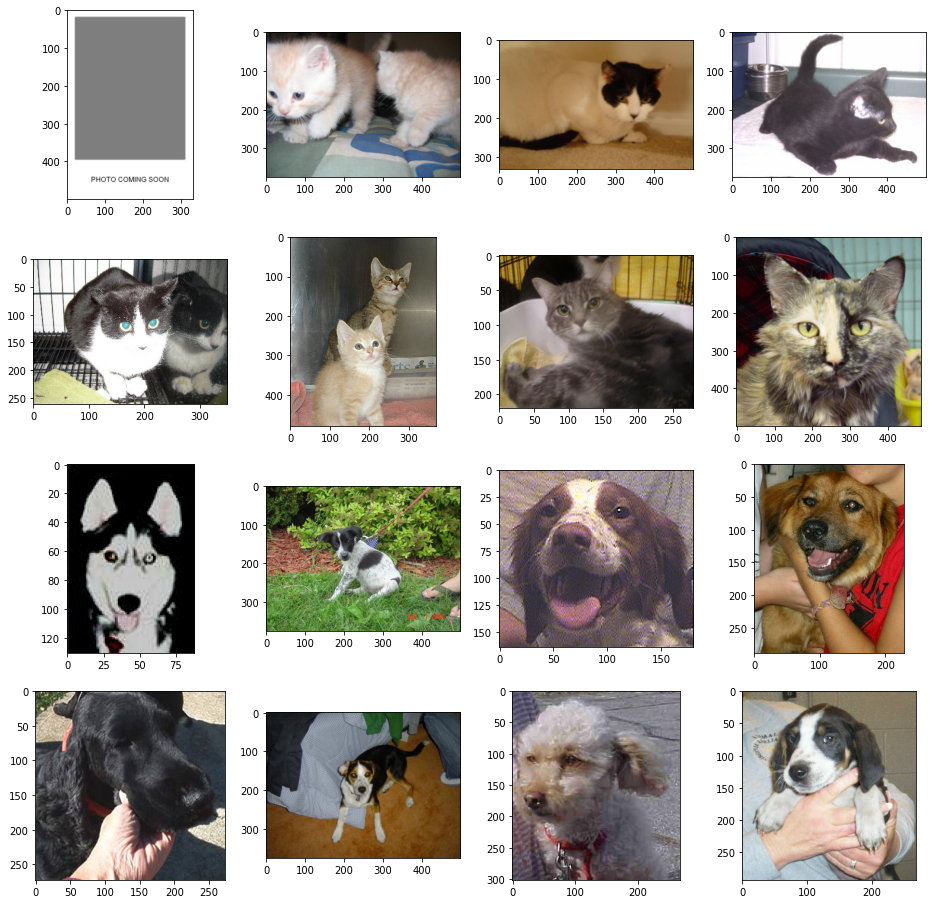

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in os.listdir(train_cats_dir)[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in os.listdir(train_dogs_dir)[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('On') 

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


In [28]:
#Pre Proccesing
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/content/cats-and-dogs/PetImages',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 300x300
        batch_size=256,
        save_format="jpg",
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')


Found 24998 images belonging to 2 classes.


In [29]:
model = keras.models.Sequential([
                                 layers.Conv2D(16, (3,3), activation="relu", input_shape=(300, 300, 3)),
                                 layers.MaxPooling2D(2,2),
                                 #Second convolution
                                 layers.Conv2D(32, (3,3), activation="relu"),
                                 layers.MaxPooling2D(2,2),
                                 #Third convolution
                                 layers.Conv2D(64, (3,3), activation="relu"),
                                 layers.MaxPooling2D(2,2),
                                 #Fourth convolution
                                 layers.Conv2D(64, (3,3), activation="relu"),
                                 layers.MaxPooling2D(2,2),
                                 #Fifth convolution
                                 layers.Conv2D(64, (3,3), activation="relu"),
                                 layers.MaxPooling2D(2,2),

                                 layers.Flatten(),
                                 layers.Dense(512, activation="relu"),
                                 layers.Dense(1, activation="sigmoid"),
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 64)       0

In [30]:
from tensorflow.keras.optimizers import RMSprop

model.compile(
    loss="binary_crossentropy",
    optimizer=RMSprop(learning_rate=0.001),
    metrics=["accuracy"],
)

In [13]:
#Callback Function
class myCallback(tf.keras.callbacks.Callback):
        # Define the correct function signature for on_epoch_end
        def on_epoch_end(self, epoch, logs={}):
            if logs.get('accuracy') >= 0.96: 
                print("\nReached 96% accuracy so cancelling training!") 
                
                # Stop training once the above condition is met
                self.model.stop_training = True

In [32]:
callbacks = myCallback()

history = model.fit(
      train_generator,
      steps_per_epoch=97,  #I have faced a problem that there are corrupt files in dataset, I dont know yet how 
      epochs=15,            # to handle them so not using all the data for training
      verbose=1,
      callbacks=[callbacks]
      )

Epoch 1/15
 4/97 [>.............................] - ETA: 1:58 - loss: 0.5469 - accuracy: 0.7305

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

97/97 [==============================] - 123s 1s/step - loss: 0.5160 - accuracy: 0.7462
Epoch 2/15
97/97 [==============================] - 123s 1s/step - loss: 0.4613 - accuracy: 0.7849
Epoch 3/15
97/97 [==============================] - 121s 1s/step - loss: 0.4087 - accuracy: 0.8113
Epoch 4/15
97/97 [==============================] - 120s 1s/step - loss: 0.3680 - accuracy: 0.8338
Epoch 5/15
97/97 [==============================] - 120s 1s/step - loss: 0.3318 - accuracy: 0.8534
Epoch 6/15
97/97 [==============================] - 122s 1s/step - loss: 0.2886 - accuracy: 0.8735
Epoch 7/15
97/97 [==============================] - 122s 1s/step - loss: 0.2624 - accuracy: 0.8871
Epoch 8/15
97/97 [==============================] - 121s 1s/step - loss: 0.2226 - accuracy: 0.9048
Epoch 9/15
97/97 [==============================] - 122s 1s/step - loss: 0.2116 - accuracy: 0.9112
Epoch 10/15
97/97 [==============================] - 122s 1s/step - loss: 0.1688 - accuracy: 0.9305
Epoch 11/15
97/97 [=

In [49]:
#Now upload and predict your image
from keras.preprocessing import image
import os

images = os.listdir("/tmp/images")

print(images)

for i in images:
  print()
  # predicting images
  path = '/tmp/images/' + i
  img = image.load_img(path, target_size=(300, 300))
  x = image.img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(i + " is a dog")
  else:
    print(i + " is a cat")
 

['labrador-retriever-g45e9dae08_640.jpg']

[0.99943274]
labrador-retriever-g45e9dae08_640.jpg is a dog
